<a href="https://colab.research.google.com/github/johnatanDM/MachineLearning/blob/main/HOMLwSKL%26TFcap3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Classificação

Baixando o dataset MNIST

In [1]:
from sklearn.datasets import fetch_openml
X,y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

In [2]:
X.shape

(70000, 784)

In [3]:
y.shape

(70000,)

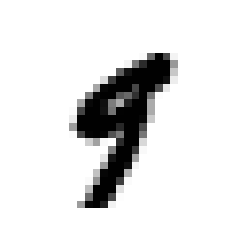

In [4]:
#vamos ver um exemplo desse dataset
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [5]:
y[36000]

'9'

In [6]:
#separar conjunto de treino e conjunto de teste
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [7]:
#emabaralhar o conjunto de treino
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

Treinando um Classificador binário

In [8]:
y_train_9 = (y_train == '9')
y_test_9 = (y_test == '9')
print(y_train_9)
y_train[0]

[ True False False ... False False False]


'9'

In [9]:
# np.unique(y_test_9)

In [10]:
#iremos usar o SGD - Gradiente Descendente Estocástico
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_9)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [11]:
#fazendo as predições
sgd_clf.predict([some_digit])

array([False])

Medindo o desempenho

In [13]:
#Validação cruzada
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_9):
  clone_cfl = clone(sgd_clf)
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_9[train_index]
  X_test_fold = X_train[test_index]
  y_test_fold = y_train_9[test_index]

  clone_cfl.fit(X_train_folds, y_train_folds)
  y_pred = clone_cfl.predict(X_test_fold)
  n_corret = sum(y_pred == y_test_fold)
  print(n_corret / len(y_pred))

0.92635
0.9522
0.91725


In [14]:
#utilizando a função cross_val_score()
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_9, cv=3, scoring="accuracy")

array([0.9418 , 0.94885, 0.9474 ])

95% de acurácia parece incrível, mas e se fizermos um classificador ridículo que apenas diz que todos não são 9. Quanto será que ele acerta?

In [15]:
from sklearn.base import BaseEstimator

class Never9Classifier(BaseEstimator):
  def fit(self, X, y=None):
    pass
  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)

never_9_clf = Never9Classifier()
cross_val_score(never_9_clf, X_train, y_train_9, cv=3, scoring="accuracy")

array([0.89975, 0.9014 , 0.9014 ])

Sim, 90% de acurácia. Isso é pq só 10% das imagens são "9" então se sempre chutar "Não 9" vai acertar 90% das vezes.

Matriz de Confusão

In [16]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_9, cv=3)

In [17]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_9, y_train_pred)

array([[51825,  2226],
       [ 1013,  4936]])

O importante da Matrix de confusão é aprender que as linhas representam a classe real e as colunas as classes previstas.


```
   S  N
S VP  FN
N FP  VN
```



Precisão e Revocação

In [19]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_9, y_train_pred))
print(recall_score(y_train_9, y_train_pred))

0.6891929628595365
0.8297192805513531


Isso significa que nosso modelo só acerta 68% das vezes em que diz que é um '9' e só detecta 82% dos '9'

Uma outra métrica combina precissão e revocação é a *pontuação F1*. Isso é útil para comparar classificadores.

In [20]:
from sklearn.metrics import f1_score
f1_score(y_train_9, y_train_pred)

0.7529555335214706

A pontuação F1 favorece classificadores com precisão e revocação similares. Nem sempre isso é o que queremos. Por exemplo se você está criando um classificador que dectecta se um vídeo é adequado para crianças é preferível que ele bloqueie bons vídeos (baixa revocação)(-FP) e mantivesse somente os adequados (alta precisão)(+VP). Não dá pra conseguir os dois altos infelizmente.

In [24]:
# Compensação da Precisão/Revocação
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[-1817.27034409]
[False]


In [25]:
threshold = -200000
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[ True]


In [26]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_9, cv=3, method="decision_function")

In [28]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_9, y_scores)

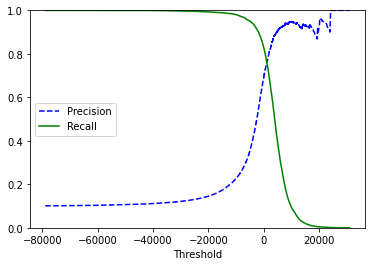

In [29]:
def plt_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
  plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
  plt.xlabel("Threshold")
  plt.legend(loc="center left")
  plt.ylim([0,1])

plt_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [31]:
y_train_pred_95 = (y_scores > 10000)

print(precision_score(y_train_9, y_train_pred_95))
print(recall_score(y_train_9, y_train_pred_95))

0.9485049833887044
0.09598251807026391


A curva ROC

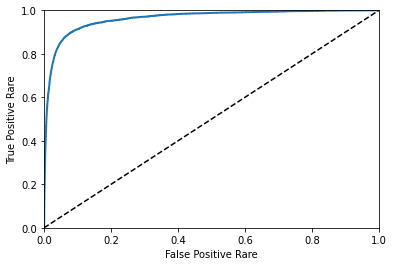

In [33]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_9, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0,1],[0,1], 'k--')
  plt.axis([0, 1, 0, 1])
  plt.xlabel('False Positive Rare')
  plt.ylabel('True Positive Rare')

plot_roc_curve(fpr, tpr)
plt.show()

In [34]:
#ROC AUC (ÁREA ABAIXO DA CURVA)
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_9, y_scores)

0.9627285666299753

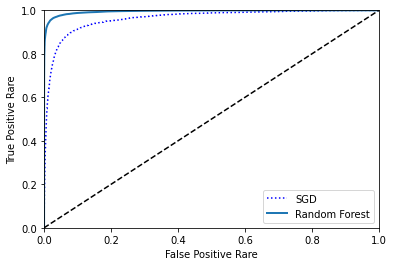

In [36]:
#comparar curva ROC com o RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_9, cv=3, method="predict_proba")

y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_9, y_scores_forest)

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [37]:
roc_auc_score(y_train_9, y_scores_forest)

0.9951840416905895